<a href="https://colab.research.google.com/github/erikyryan/document-classification/blob/main/document_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pré-processamento dos dados

Foram realizadas várias etapas de pré-processamento para garantir que os dados estivessem no formato correto. Primeiro, foi lida a base de dados e filtrados os arquivos pelo tipo desejado. Em seguida, foi alterado o tamanho das imagens para garantir que elas fossem compatíveis com os modelos. Por fim, foram preparados os dados para execução nos modelos.



## Import das funções

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import random
import requests
import os
import zipfile
import glob
import cv2
import tensorflow as tf

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from random import randint

from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

In [17]:
def process_images(filepath, size, max_files=3500):
    filenames = []
    readed_imgs = []
    resized_imgs = []
    i = 0

    # Read file paths
    for filename in glob.glob(filepath):
        if ('segmentation' not in filename) and filename.endswith('.jpg') and i < max_files:
            filenames.append(filename)
            i += 1
        else:
            os.remove(filename)

    # Read images
    for img in filenames:
        readed_imgs.append(cv2.imread(img))

    # Resize images
    for img in readed_imgs:
        resized_imgs.append(cv2.resize(img, size))

    return resized_imgs

def started_values(x_values: list,y_values: list):
	x_values = np.concatenate(x_values,axis=0)
	y_values = np.array(y_values)
	y_values = y_values.reshape(-1)
	x_values = x_values.reshape(len(y_values),-1)

	return x_values,y_values

def result(test):
	if test == 1 or test == 2 or test == 3:
		return 'CNH'
	elif test == 4 or test == 5:
		return 'CPF'
	elif test == 7 or test == 6 or test == 8:
		return 'RG'
	else: return None

## Download e Extração das imagens de treinamento

In [18]:
pathSample = 'https://drive.google.com/uc?id=144EqqmMtCziua9iYo-3afUEvZrJVxUXU&export=download&confirm=t&uuid=363cbdc1-ef8d-40e3-ac8f-92e8efbac4de&at=AKKF8vwO3Rerxp4Y4e7nvK22YqGB:1687737101639' #Database Sample
compressionSamplePath = '/content/storage/sample.zip'
sourcePath = '/content/storage'

if not(os.path.isdir(sourcePath)):
  os.mkdir('storage') #diretorio para armazenar os arquivos baixados.

In [19]:
response = requests.post(pathSample)

with open(compressionSamplePath, 'wb') as file:
    file.write(response.content)

with zipfile.ZipFile(compressionSamplePath, 'r') as zip_ref:
    zip_ref.extractall(sourcePath)


## Formatação dos documentos

In [20]:
cnh_aberta =  process_images(sourcePath +'/BID Sample Dataset/CNH_Aberta/*', (256,256))

cnh_frente =  process_images(sourcePath +'/BID Sample Dataset/CNH_Frente/*', (256,256))

cnh_verso =  process_images(sourcePath +'/BID Sample Dataset/CNH_Verso/*', (256,256))

# Formatação dos CPFs

cpf_frente =  process_images(sourcePath +'/BID Sample Dataset/CPF_Frente/*', (256,256))

cpf_verso =  process_images(sourcePath +'/BID Sample Dataset/CPF_Verso/*', (256,256))


# Formatação dos RGs

rg_frente =  process_images(sourcePath +'/BID Sample Dataset/RG_Frente/*', (256,256))

rg_verso =  process_images(sourcePath +'/BID Sample Dataset/RG_Verso/*', (256,256))

rg_aberto =  process_images(sourcePath +'/BID Sample Dataset/RG_Aberto/*', (256,256))




## Preparação dos dados para o treinamento

In [21]:
labels = [1,2,3,4,5,6,7,8]
documents = []

for a,b,c,d,e,f,g,h in zip(cnh_aberta,cnh_frente,cnh_verso,cpf_frente,cpf_verso,rg_frente,rg_verso,rg_aberto):
	documents.append({'x':a,'y':labels[0]})
	documents.append({'x':b,'y':labels[1]})
	documents.append({'x':c,'y':labels[2]})
	documents.append({'x':d,'y':labels[3]})
	documents.append({'x':e,'y':labels[4]})
	documents.append({'x':f,'y':labels[5]})
	documents.append({'x':g,'y':labels[6]})
	documents.append({'x':h,'y':labels[7]})


In [22]:
x_train = []
y_train = []

x_test = []
y_test = []

np.random.shuffle(documents)

x_train = [document['x'] for document in documents[:1000]]
y_train = [document['y'] for document in documents[:1000]]

x_test = np.array([document['x'] for document in documents[:2000]])
y_test = np.array([document['y'] for document in documents[:2000]])

In [23]:
# x_train, y_train = started_values(x_train,y_train)
# x_test, y_test = started_values(x_test,y_test)

In [24]:


x = [document['x'] for document in documents]
y = [document['y'] for document in documents]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_train = np.array(x_train)
n_samples = x_train.shape[0]
x_train = x_train.reshape((n_samples, -1))

x_test = np.array(x_test)
n_samples = x_test.shape[0]
x_test = x_test.reshape((n_samples, -1))

y_test = np.array(y_test)
y_train = np.array(y_train)


# Modelo SVC

SVC é a sigla para **Support Vector Classification**, que é um tipo de **Support Vector Machine (SVM)**, um algoritmo de aprendizado de máquina supervisionado que pode ser usado para desafios de classificação ou regressão. A principal diferença entre SVM e SVC é que se o hiperplano classifica o conjunto de dados linearmente, então o algoritmo é chamado de SVC e o algoritmo que separa o conjunto de dados por abordagem não linear é chamado de SVM.


In [25]:
svc = SVC(probability=True, kernel='linear')
svc.fit(x_train, y_train)

SVC(kernel='linear', probability=True)

In [26]:
y_pred = svc.predict(x_test)
y_pred_proba = svc.predict_proba(x_test)

In [27]:
accuracy = accuracy_score(y_test, y_pred)
loss = log_loss(y_test, y_pred_proba)

In [28]:
print(f'Acurácia: {accuracy:.2f}')
print(f'Perda Logarítmica: {loss:.2f}')

Acurácia: 0.98
Perda Logarítmica: 0.31


# Rede neural convolucional

In [29]:
x_train = x_train.reshape(len(x_train),256, 256, 3)
x_test = x_test.reshape(len(x_test), 256, 256, 3)
y_test = y_test.reshape(len(y_test), 1)
y_train = y_train.reshape(len(y_train), 1)

## Criando um gerador de aumento de dados

In [30]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

## Construindo o modelo

In [31]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
classifier.add(MaxPooling2D((2, 2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D((2, 2)))
classifier.add(Dropout(0.25))

classifier.add(Flatten())
classifier.add(Dense(128, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(1, activation='sigmoid'))

## Compilando o modelo

In [32]:
classifier.compile( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## Treinando a Rede Neural Convolucional

**pochs** é um hiperparâmetro que define o número de vezes que o modelo deve iterar sobre todo o conjunto de treinamento durante o treinamento.

**batch_size** é um hiperparâmetro que define o número de amostras a serem processadas pelo modelo de uma só vez.

In [33]:
batch_size = 64
steps_per_epoch = len(x_train) // batch_size
classifier.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=5, steps_per_epoch=steps_per_epoch)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 35s 8s/step - loss: 0.0000e+00 - accuracy: 0.1046
Epoch 2/5
3/3 [==============================] - 25s 7s/step - loss: 0.0000e+00 - accuracy: 0.1503
Epoch 3/5
3/3 [==============================] - 25s 7s/step - loss: 0.0000e+00 - accuracy: 0.1242
Epoch 4/5
3/3 [==============================] - 27s 7s/step - loss: 0.0000e+00 - accuracy: 0.1373
Epoch 5/5
3/3 [==============================] - 29s 11s/step - loss: 0.0000e+00 - accuracy: 0.1307


In [34]:
loss, acc = classifier.evaluate(x_test, y_test)
print("Acurácia: ", acc)
print("valor de perda: ",loss)

2/2 [==============================] - 2s 805ms/step - loss: 0.0000e+00 - accuracy: 0.0727
Acurácia:  0.072727270424366
valor de perda:  0.0


In [46]:
from tensorflow.keras.utils import to_categorical

classification = ['CNH','CNH','CNH','CPF','CPF','RG','RG','RG']

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [36]:
test_loss, test_acc = classifier.evaluate(x_test, y_test)
print("Accuracy: ", test_acc)

2/2 [==============================] - 2s 978ms/step - loss: 0.0000e+00 - accuracy: 0.0727
Accuracy:  0.072727270424366


## Teste do modelo exemplo

Saving rg-frente.jpg to rg-frente (2).jpg


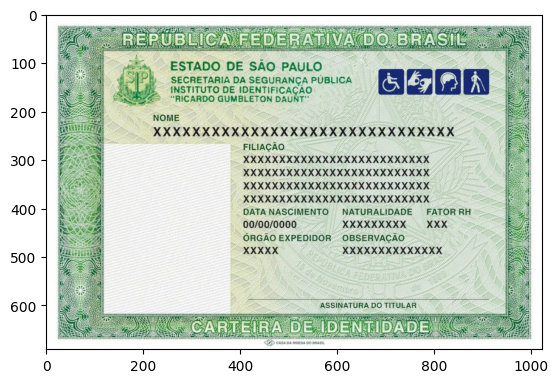

In [37]:
from google.colab import files
uploaded = files.upload()

#show the image
new_img = plt.imread('rg-frente.jpg')
img = plt.imshow(new_img)

### Resize na imagem

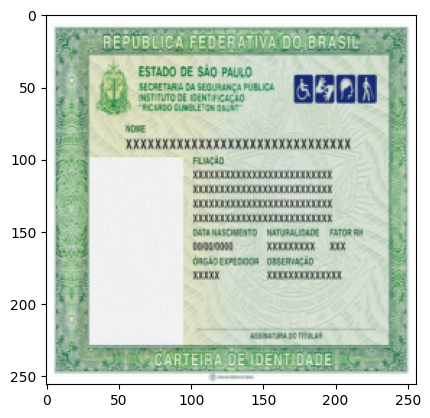

In [40]:
#resize image
from skimage.transform import resize
resized_image = resize(new_img,(256,256,3))
img = plt.imshow(resized_image)

## Predictions

In [43]:
predictions = classifier.predict(np.array([resized_image])) #Get the models predictions

1/1 [==============================] - 0s 116ms/step


In [44]:
predicted_class = np.argmax(predictions[0])

In [45]:
# Imprima o resultado
print(f'Classe prevista: {predicted_class}')

Classe prevista: 0


@inproceedings{sibgrapi_estendido,
 author = {Álysson Soares and Ricardo das Neves Junior and Byron Bezerra},
 title = {BID Dataset: a challenge dataset for document processing tasks},
 booktitle = {Anais Estendidos do XXXIII Conference on Graphics, Patterns and Images},
 location = {Evento Online},
 year = {2020},
 keywords = {},
 issn = {0000-0000},
 pages = {143--146},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/sibgrapi.est.2020.12997},
 url = {https://sol.sbc.org.br/index.php/sibgrapi_estendido/article/view/12997}
}